In [8]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fmin_cg
import scipy.io as si
from scipy.io import loadmat
from scipy.optimize import minimize
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load Data

In [11]:
data = loadmat('ex4data1.mat')
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [12]:

X = data['X']
y = data['y']

yy = data['y'].flatten()

# replace 10 -> 0 
# re-cast y

y = np.zeros((len(yy), 10))
for ii in range(y.shape[0]):
    y[ii, yy[ii]-1] = 1
    

print('\nX:',X.shape, '(without intercept)')
print('y:',y.shape)


m,n = X.shape

print('\nNumber of features (n): %.0f'%(n))
print('Number of training examples (nm): %.0f'%(m))





X: (5000, 400) (without intercept)
y: (5000, 10)

Number of features (n): 400
Number of training examples (nm): 5000


In [15]:
weights = loadmat('ex4weights.mat')
print(weights.keys())

theta1, theta2 = weights['Theta1'], weights['Theta2']
print('\ntheta1 :', theta1.shape)
print('theta2 :', theta2.shape)

nn_params = np.concatenate((np.reshape(theta1, theta1.size, order = 'F'),
                            np.reshape(theta2, theta2.size, order = 'F')))
print('params :', nn_params.shape)

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

theta1 : (25, 401)
theta2 : (10, 26)
params : (10285,)


#  Display data

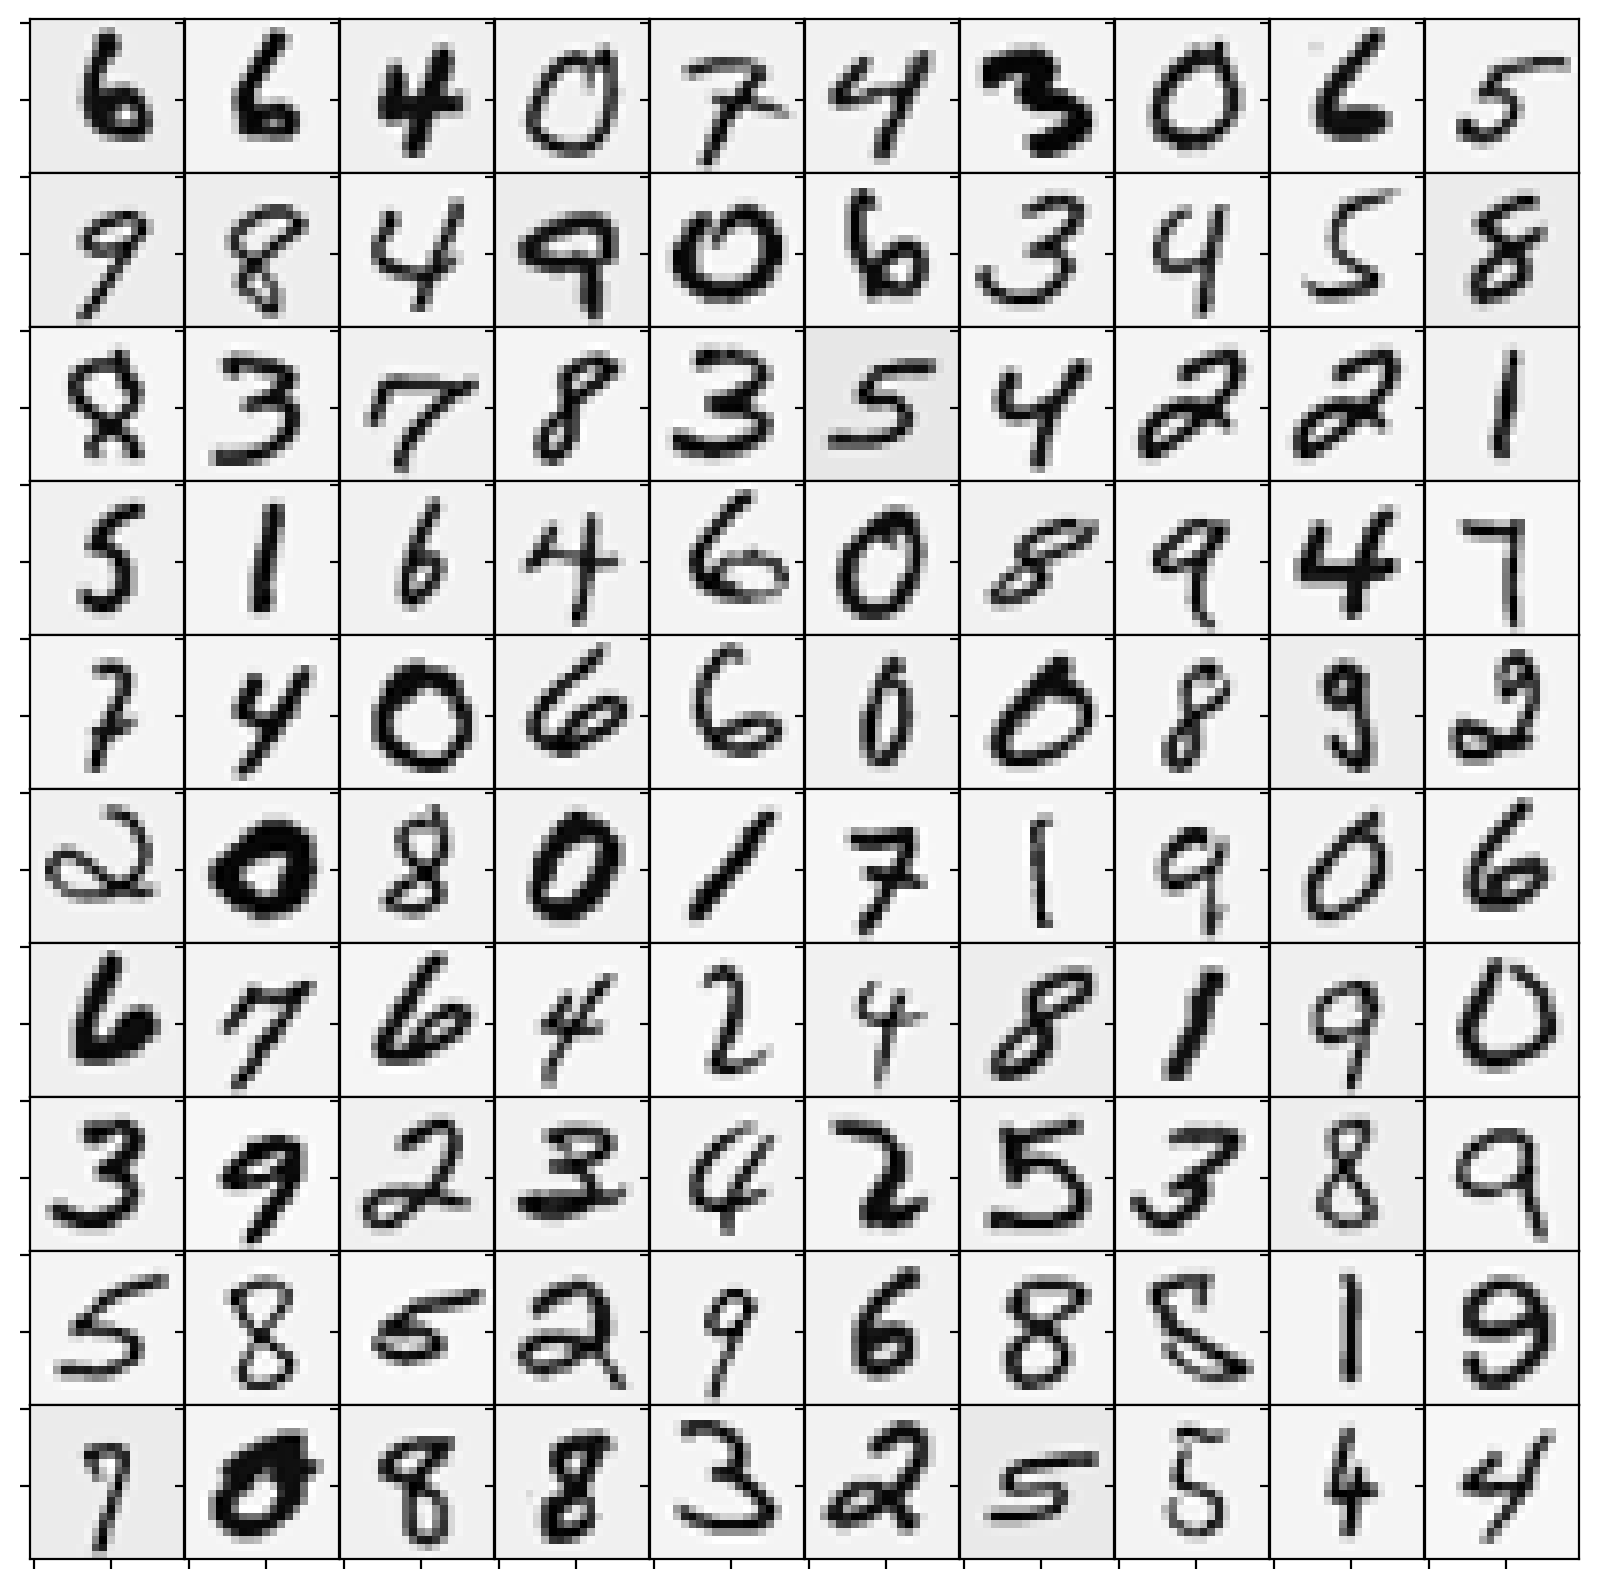

In [16]:
def displayData(X, nrows = 10, ncols = 10):
    
    # set up array
    fig, axarr = plt.subplots(nrows = nrows, ncols = ncols,
                              figsize = (nrows, ncols))
    
    # loop over randomly drawn numbers
    for ii in range(nrows):
        for jj in range(ncols):
            ind = np.random.randint(X.shape[0])
            tmp = X[ind,:].reshape(20, 20, order = 'F')
            axarr[ii,jj].imshow(tmp, cmap = 'gray_r')
            plt.setp(axarr[ii,jj].get_xticklabels(), visible = False)
            plt.setp(axarr[ii,jj].get_yticklabels(), visible = False)
    
    fig.subplots_adjust(hspace = 0, wspace = 0)
    
displayData(X)

# sigmoid and sigmoid Gradient Functions

At 0 sigmoid gradient is 0.25


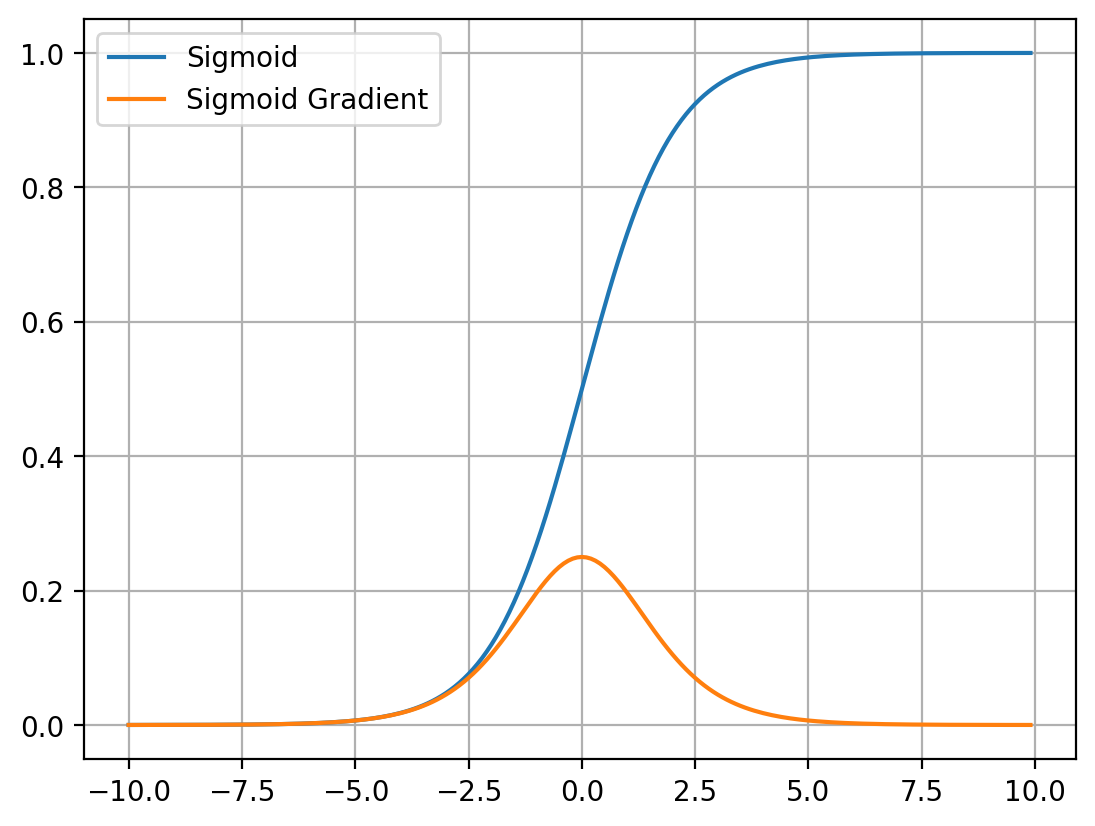

In [17]:
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return(g)

def sigmoidGradient(z):
    dg = sigmoid(z) * (1 - sigmoid(z))
    return(dg)


Xaxis = np.arange(-10,10, 0.1)

print('At 0 sigmoid gradient is', sigmoidGradient(0))


plt.plot(Xaxis, sigmoid(Xaxis), label = 'Sigmoid')
plt.plot(Xaxis, sigmoidGradient(Xaxis), label = 'Sigmoid Gradient')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
L = 400 # Input layer size = 400 (20x20 pixels)
input_layer_size = 400 
hidden_layer_size = 25
num_labels = 10 

In [29]:
 def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, reg):
    eps = 1e-15
    
    # sizes
    m, n = X.shape
    
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size +1)],
                        (hidden_layer_size, input_layer_size + 1), order = 'F')
    
    Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                        (num_labels, (hidden_layer_size + 1)), order = 'F')
    
    # add ones to X data matrix
    X = np.hstack((np.ones((m, 1)), X))
    
    # hidden layer
    z2 = np.dot(X, Theta1.T)
    a2 = sigmoid(z2)
    
    #add bias unit to a2
    a2 = np.hstack((np.ones((a2.shape[0],1)), a2))

    # output layer
    z3 = np.dot(a2, Theta2.T)
    htheta = sigmoid(z3)
    
    # cost function
    J = - 1 / m * np.sum((np.sum(np.log(htheta) * y) + np.sum(np.log(1 - htheta + eps) * (1 - y))\
                          - reg / 2 * (np.sum(Theta1[:, 1:]**2) + np.sum(Theta2[:, 1:] ** 2)))) 
    
    """
    Part 2: Implement the backpropagation algorithm to compute the gradients
              Theta1_grad and Theta2_grad. You should return the partial derivatives of
              the cost function with respect to Theta1 and Theta2 in Theta1_grad and
              Theta2_grad, respectively. 
    """
        
    # back prop
    delta3 = htheta - y
    delta2 = np.dot(delta3, Theta2)[:,1:] * sigmoidGradient(z2)
    #print np.dot(htheta, Theta2)[:,1:].shape, sigmoidGradient(z2).shape
        
    Delta1 = np.dot(delta2.T, X)
    Delta2 = np.dot(delta3.T, a2)
    
    Theta1_grad = 1 / m * Delta1
    Theta2_grad = 1 / m * Delta2
    
    # regularization
    Theta1_grad[:,1:] += reg / m * Theta1[:,1:]
    Theta2_grad[:,1:] += reg / m * Theta2[:,1:]
                
    # pack gradient
    grad = np.concatenate((np.reshape(Theta1_grad, Theta1_grad.size, order='F'),
                            np.reshape(Theta2_grad, Theta2_grad.size, order='F')))
    

    return(J, grad)
reg = 0.1
J, grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, reg - 0)
print('Cost at parameters (loaded from ex4weights): %.6f' % J)



Cost at parameters (loaded from ex4weights): 0.297243


# Random Initialization

In [31]:
def randInitializeWeights(L_in, L_out):
   
    epsilon_int = 0.12
    eps_rand = np.random.rand(L_out, 1 +  L_in) * 2 * epsilon_int - epsilon_int
    
    return(eps_rand)

In [44]:
def computeNumericalGradient(J, theta):
    
    numgrad = np.zeros(len(theta))
    perturb = np.zeros(len(theta))
    e = 1e-4
    for p in range(len(theta)):
        
        # Set perturbarion vactor
        perturb[p] = e
        loss1 = J(theta - perturb)
        loss2 = J(theta + perturb)
        
        # compute numerical gradient
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
        
    return numgrad

def checkNNGradients(reg = 0):
    
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    
    # generate some random test data
    Theta1 = randInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = randInitializeWeights(num_labels, hidden_layer_size)
    
    X = randInitializeWeights(input_layer_size - 1, m)
    yy = 1 + np.mod(np.arange(m), num_labels)
    
    # re-cast y
    y = np.zeros((len(yy), num_labels))
    for ii in range(y.shape[0]):
        y[ii, yy[ii] - 1] = 1
        
    # unroll parameters
    nn_params = np.concatenate((np.reshape(Theta1, Theta1.size, order = 'F'),
                            np.reshape(Theta2, Theta2.size, order = 'F')))
    
    # cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, reg)[0]
    
    cost, grad = nnCostFunction(nn_params, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, reg)
    numgrad = computeNumericalGradient(costFunc, nn_params)
    
    cnt = 0
    print('Gradient Checking for Lambda = %.1f'%(reg))
    print('Count \t\t title \t\t\t title \t\t\tDifference')
    for g, ng in zip(grad, numgrad):
        print('%.0f. \t %.15f \t  %.15f \t %.15f'%(cnt, g, ng, np.abs(g - ng) / ng))
        cnt += 1
    print('\n\n')
    
# checkNNGradients()
# checkNNGradients(3)
# checkNNGradients(5)

# regularization

In [33]:


# Regularization parameter = 0
reg = 0
nnCostFunction(nn_params, input_layer_size, 25, 10, X, y, reg)[0]

#print('For Lambda = %.0f, \n\tCost  = %.2f \n\t Theta1_grad = %.2f \n\t Theta2_grad = %.2f' %(Lambda, J, theta1_grad, theta2_grad ) )


# Regularization parameter = 1]
reg = 1
nnCostFunction(nn_params, input_layer_size, 25, 10, X, y, reg)[0]


[sigmoidGradient(z) for z in [-1, -0.5, 0, 0.5, 1]]



[0.19661193324148185,
 0.2350037122015945,
 0.25,
 0.2350037122015945,
 0.19661193324148185]

In [34]:
def predict(Theta1, Theta2, X):
    
    # sizes
    m, n = X.shape
    num_labels = Theta2.shape[0]
    
    # add ones to X data matrix
    X = np.hstack((np.ones((m, 1)), X))
        
    # hidden layer
    z2 = np.dot(X, Theta1.T)
    a2 = sigmoid(z2)

    #add bias unit to a2
    a2 = np.hstack((np.ones((a2.shape[0],1)), a2))

    # output layer
    z3 = np.dot(a2, Theta2.T)
    a3 = sigmoid(z3)

    p = np.argmax(a3, axis=1)
    
    return p


reg = 1
maxiter = 400

# function prototypes
cost = lambda x: nnCostFunction(x, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, reg)[0]

grad = lambda x: nnCostFunction(x, input_layer_size,
                         hidden_layer_size, num_labels, 
                         X, y, reg)[1]

# initialize parameters
init_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
init_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

init_nn_params = np.concatenate((np.reshape(init_Theta1, init_Theta1.size, order = 'F'),
                            np.reshape(init_Theta2, init_Theta2.size, order = 'F')))

# run minimization
nn_params = fmin_cg(cost, init_nn_params, fprime=grad, maxiter=maxiter, disp=False)

# Reshape nn_params back into the parameters for Theta
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                    (hidden_layer_size, input_layer_size + 1), order = 'F')
Theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):], 
                    (num_labels, (hidden_layer_size + 1)), order = 'F')

p = predict(Theta1, Theta2, X)
print('Training set Accuracy: %2.2f percent' % (np.mean(p + 1 == yy) * 100))

Training set Accuracy: 99.52 percent


In [35]:
# Hidden layer 

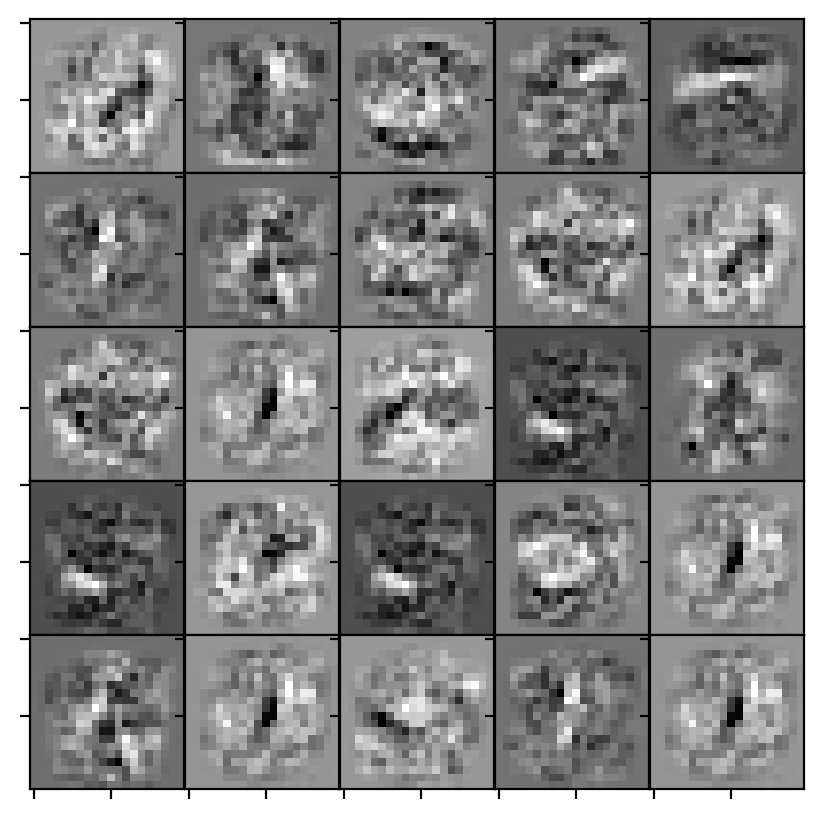

In [36]:


displayData(Theta1[:,1:], nrows = 5, ncols = 5)

